In [32]:
# Modified from
#   https://blog.keras.io/building-autoencoders-in-keras.html
#   https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

In [33]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 1.0

We will define 'encoder' and 'decoder' as separate models so we can use them separately later.<br>
Our VAE will be built from these and its learnt parameters will be shared with these models.<br><br>

I am doing this because [recreating the encoder](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py#L66-L67) and [recreating the decoder](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py#L77-L80) after training <br>
feels sort of hackish and duplicates code needlessly.

In [34]:
# Encoder
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2.) * epsilon

# Note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(input=x, output=z)
encoder.compile(optimizer='adadelta', loss='binary_crossentropy')  
# We have to call compile in order to compose models for our VAE.
# The arguments are 'mandatory' but they will serve no purpose here, because we won't train 'encoder' directly.

In [35]:
# Decoder
decoder_input = Input(shape=(latent_dim,))
decoder_h = Dense(intermediate_dim, activation='relu')(decoder_input)
decoder_mean = Dense(original_dim, activation='sigmoid')(decoder_h)

decoder = Model(input=decoder_input, output=decoder_mean)
decoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [36]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(input=x, output = decoder(encoder(x)))

# Pass in a custom loss function as per https://keras.io/objectives/
# Loss function takes the ground-truth and predictions as arguments, in that order.
#   The ground-truth is supplied when calling vae.fit (see next code cell)
#   The prediction is supplied as output from vae (so here, predictions are from decoder).
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [37]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# second argument is ground-truth
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/75
60000/60000 [==============================] - 8s - loss: 191.5799 - val_loss: 173.9743
Epoch 2/75
60000/60000 [==============================] - 10s - loss: 170.7337 - val_loss: 167.8010
Epoch 3/75
60000/60000 [==============================] - 12s - loss: 166.3449 - val_loss: 164.8833
Epoch 4/75
60000/60000 [==============================] - 13s - loss: 164.0930 - val_loss: 162.8575
Epoch 5/75
60000/60000 [==============================] - 14s - loss: 162.5112 - val_loss: 161.9873
Epoch 6/75
60000/60000 [==============================] - 14s - loss: 161.3803 - val_loss: 160.7714
Epoch 7/75
60000/60000 [==============================] - 14s - loss: 160.4378 - val_loss: 159.9810
Epoch 8/75
60000/60000 [==============================] - 14s - loss: 159.6531 - val_loss: 159.3384
Epoch 9/75
60000/60000 [==============================] - 14s - loss: 159.0112 - val_loss: 159.4319
Epoch 10/75
60000/60000 [==========================

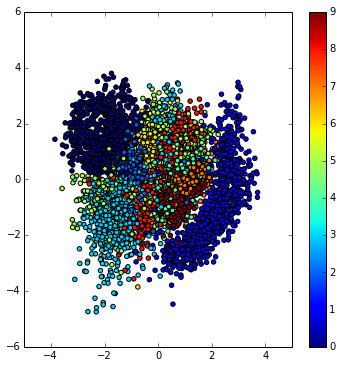

In [38]:
%matplotlib inline

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

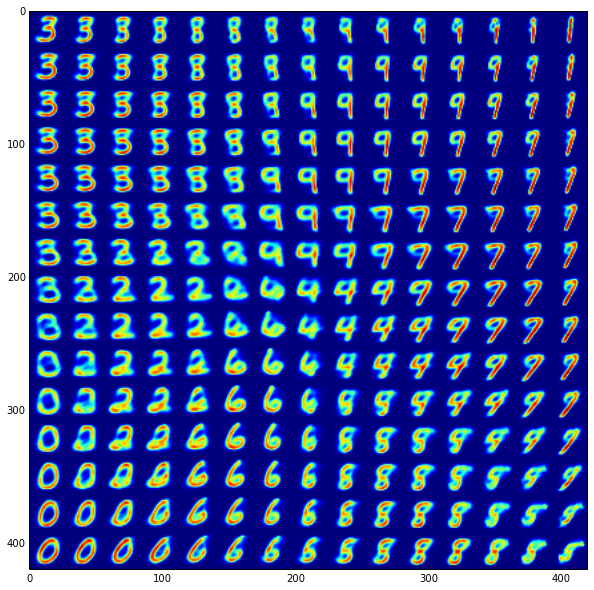

In [39]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
#plt.imshow(figure, cmap='Greys_r')
plt.imshow(figure)
plt.show()